## Authenticate to Colab, Cloud and GEE

In [1]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Yolo_2/'
model_dir = base_dir + 'models/'
IMAGES_PATH = base_dir + '/' + 'Yolo_2016_16c/'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


## Import Libraries

In [2]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


In [3]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


In [4]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


# Initialize global variables and functions

In [5]:
LABEL = 'landcover'


# landcovers = ['Rice', 'Alfalfa', 'Wheat', 'Sunflower', 'Safflower', 'Corn', 'YP', 'Tomatoes', 
#               'Grain and Hay', 'Grapes', 'Deciduous','Subtropical', 'Other Grass', 'Other Crops',
#               'Wetland', 'Fallowland', 'Buildup'];
landcovers = ["Rice", "Safflower", "Corn", "Other Field crops", "Alfalfa", "Other Pasture", "Cucurbits", "Tomatoes", 
             "Other Truck Crops", "Almonds and pistachios", "Other Deciduous", "Subtropical", "Vineyards", "Other"]
nClasses = 16
r = 7

In [6]:
# new_labels = tf.constant([0,1,2,3,4,5,6,13,7,13,13,13,13,13,10,13,13,13,13,8,13,13,11,10,10,10,10,9,10,10,11,11,10,10,11,13,12,10,12,13,14,15,16], dtype = tf.int32,)
# new_labels = tf.constant([0,1,2,3,4,5,6,13,7,13,13,13,13,13,10,13,13,13,13,8,13,13,11,10,10,10,10,9,10,10,11,11,10,10,11,13,12,10,12,13,14,15,16], dtype = tf.int32,)
new_labels = tf.constant([0,4,13,3,1,2,13,6,7,8,8,8,8,8,10,3,8,8,8,13,3,8,11,10,9,9,10,12,10,10,11,11,10,10,11,8,5,10,5,8,13,13,13], dtype = tf.int32,)

new_labels

<tf.Tensor: shape=(43,), dtype=int32, numpy=
array([ 0,  4, 13,  3,  1,  2, 13,  6,  7,  8,  8,  8,  8,  8, 10,  3,  8,
        8,  8, 13,  3,  8, 11, 10,  9,  9, 10, 12, 10, 10, 11, 11, 10, 10,
       11,  8,  5, 10,  5,  8, 13, 13, 13], dtype=int32)>

In [7]:
train_path = IMAGES_PATH + 'training_yolo_2016_16c'
validation_path = IMAGES_PATH + 'validation_yolo_2016_16c'
test_path = IMAGES_PATH + 'testing_yolo_2016_16c'

train_file_prefix = 'training_yolo_2016'
validation_file_prefix = 'validation_yolo_2016'
test_file_prefix = 'testing_yolo_2016'

def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

train_dataset_paths = getDatasetPaths(train_path, train_file_prefix)
validation_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)


In [ ]:
validation_dataset_paths

In [23]:
FEATURE_NAMES = []
bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7', 'NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']
# bands =  ['NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']

# bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7']

time_stamps = 9
n_features = len(bands)
for i in range(time_stamps):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)
# for b in bands:
#   for i in range(time_stamps):
#     if i > 0:
#       s = b + '_' + str(i)
#     else:
#       s = b
#     FEATURE_NAMES.append(s)  
  
# FEATURE_NAMES.append(LABEL)
# FEATURE_NAMES

# Data preparation and pre-processing

In [24]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES
]
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))

# pprint(featuresDict)

In [25]:
# Create a dataset from the TFRecord file in Cloud Storage.

depth = len(FEATURE_NAMES)-1
def toTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    for f in FEATURE_NAMES[i:i+n_features]:
      if f.startswith('B'):
        spectral.append(tf.reshape(data[f],(r,r))/10000)
      else:   
        spectral.append(tf.reshape(data[f],(r,r)))
  
  spectral = tf.transpose(spectral, [1,2,0])
  label = tf.gather(new_labels, label)

  return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, label

def getDataset(datasetPaths):
  dataset = tf.data.TFRecordDataset(datasetPaths, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(toTuple)
  return inputDataset

trainDataset = getDataset(train_dataset_paths)
validationDataset = getDataset(validation_dataset_paths)
testDataset = getDataset(test_dataset_paths)
alltestDataset = validationDataset.concatenate(testDataset)

In [26]:
for data, target in testDataset.take(5):
  print(data.shape)
  # print(data)
  print(target)

(7, 7, 117)
tf.Tensor(0, shape=(), dtype=int32)
(7, 7, 117)
tf.Tensor(7, shape=(), dtype=int32)
(7, 7, 117)
tf.Tensor(12, shape=(), dtype=int32)
(7, 7, 117)
tf.Tensor(13, shape=(), dtype=int32)
(7, 7, 117)
tf.Tensor(0, shape=(), dtype=int32)


# 2D CNN

In [27]:
pad = 'same'
l2 = 0
l1 = 0

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape = ( r, r, time_stamps*n_features),),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.Dense(14, activation = 'softmax')
# ])
# model.summary()
def unit(f = 60):
    model = tf.keras.Sequential([   
      tf.keras.layers.Conv2D(filters = f, kernel_size = (5, 5), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(filters = f, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(f, activation = 'relu'),
    ])
    return model

def model():
  input = tf.keras.layers.Input(shape = ( r, r, time_stamps*n_features))
  x = tf.keras.layers.BatchNormalization()(input)
  unit1 = unit(160)(x)
  unit2 = unit(170)(x)
  unit3 = unit(180)(x)
  unit4 = unit(190)(x)
  unit5 = unit(200)(x)
  x = tf.keras.layers.Concatenate()([unit1, unit2, unit3, unit4, unit5])
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(14, activation = 'softmax')(x)
  model = tf.keras.Model(input, x)
  return model

model = model()
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 7, 7, 117)]  0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 7, 7, 117)    468         input_7[0][0]                    
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 160)          724480      batch_normalization_5[0][0]      
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 170)          786760      batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model)

In [29]:
batch_size = 128
num_epochs = 60

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, min_lr=1e-10, min_delta=0.01, verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_dir + '/model2_conv2d_2016_7x7x117', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

history = model.fit(trainDataset.batch(batch_size), 
                    batch_size=batch_size, 
                    epochs=num_epochs, verbose=1,
                    validation_data = alltestDataset.batch(batch_size),
                    callbacks = [reduce_lr, 
                                 model_checkpoint_callback
                                 ]
)

Epoch 1/60
1217/1217 [==============================] - 121s 99ms/step - loss: 0.7681 - accuracy: 0.7751 - val_loss: 0.5241 - val_accuracy: 0.8744
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Classification/USA/Yolo_2/models/model2_conv2d_2016_7x7x117/assets
Epoch 2/60
1217/1217 [==============================] - 120s 98ms/step - loss: 0.3371 - accuracy: 0.9027 - val_loss: 0.5853 - val_accuracy: 0.8703
Epoch 3/60
1217/1217 [==============================] - 117s 96ms/step - loss: 0.2580 - accuracy: 0.9260 - val_loss: 0.6169 - val_accuracy: 0.8703

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 4/60
1217/1217 [==============================] - 118s 97ms/step - loss: 0.2116 - accuracy: 0.9397 - val_loss: 0.6591 - val_accuracy: 0.8723
Epoch 5/60
1217/1217 [==============================] - 117s 96ms/step - loss: 0.1751 - accuracy: 0.9495 - val_loss: 0.7037 - val_accuracy: 0.8788

Epoch 00005: ReduceLROnPlateau reducing 

KeyboardInterrupt: ignored

In [30]:
# model = tf.keras.models.load_model(model_dir + '/model1_conv2d_2016_7x7x117')
model = tf.keras.models.load_model(model_dir + '/model2_conv2d_2016_7x7x117')

In [31]:
model.evaluate(alltestDataset.batch(1000))

128/128 [==============================] - 53s 403ms/step - loss: 1.5070 - accuracy: 0.8850


[1.506966471672058, 0.8849766850471497]

## Analysis

[[13830     4    14    15     5     9    30   130     6    26    24     2
     10   276]
 [   12  2870    96    35    82    12    23     4    10    59     2     0
      5   119]
 [   28    18  1505   373    40     5   102   371    13     0     3     0
     10   173]
 [   30   211    72  6065    58     0   260   568    29     6    13     0
      0   312]
 [   20    97     5    22  9264   177    23    41    27     7    54     1
     23   261]
 [   11    12     0    15   260  4002     0    17    64    10    31     5
      8   338]
 [    4     3    26    28    60    12  1485   178   122     1    20     0
      4   135]
 [   17     4    78   145    22     3   148  9300    64    15     2     1
      3   204]
 [    5    28    70    26    36    11   215   196   801    42    47     3
      9   393]
 [   23    13     0    20    27     6     3    21    46  8621   125    33
    148  1468]
 [   28     5     3    10    46    16     5    10    62    67  5402    16
    122   300]
 [   13     0     0  

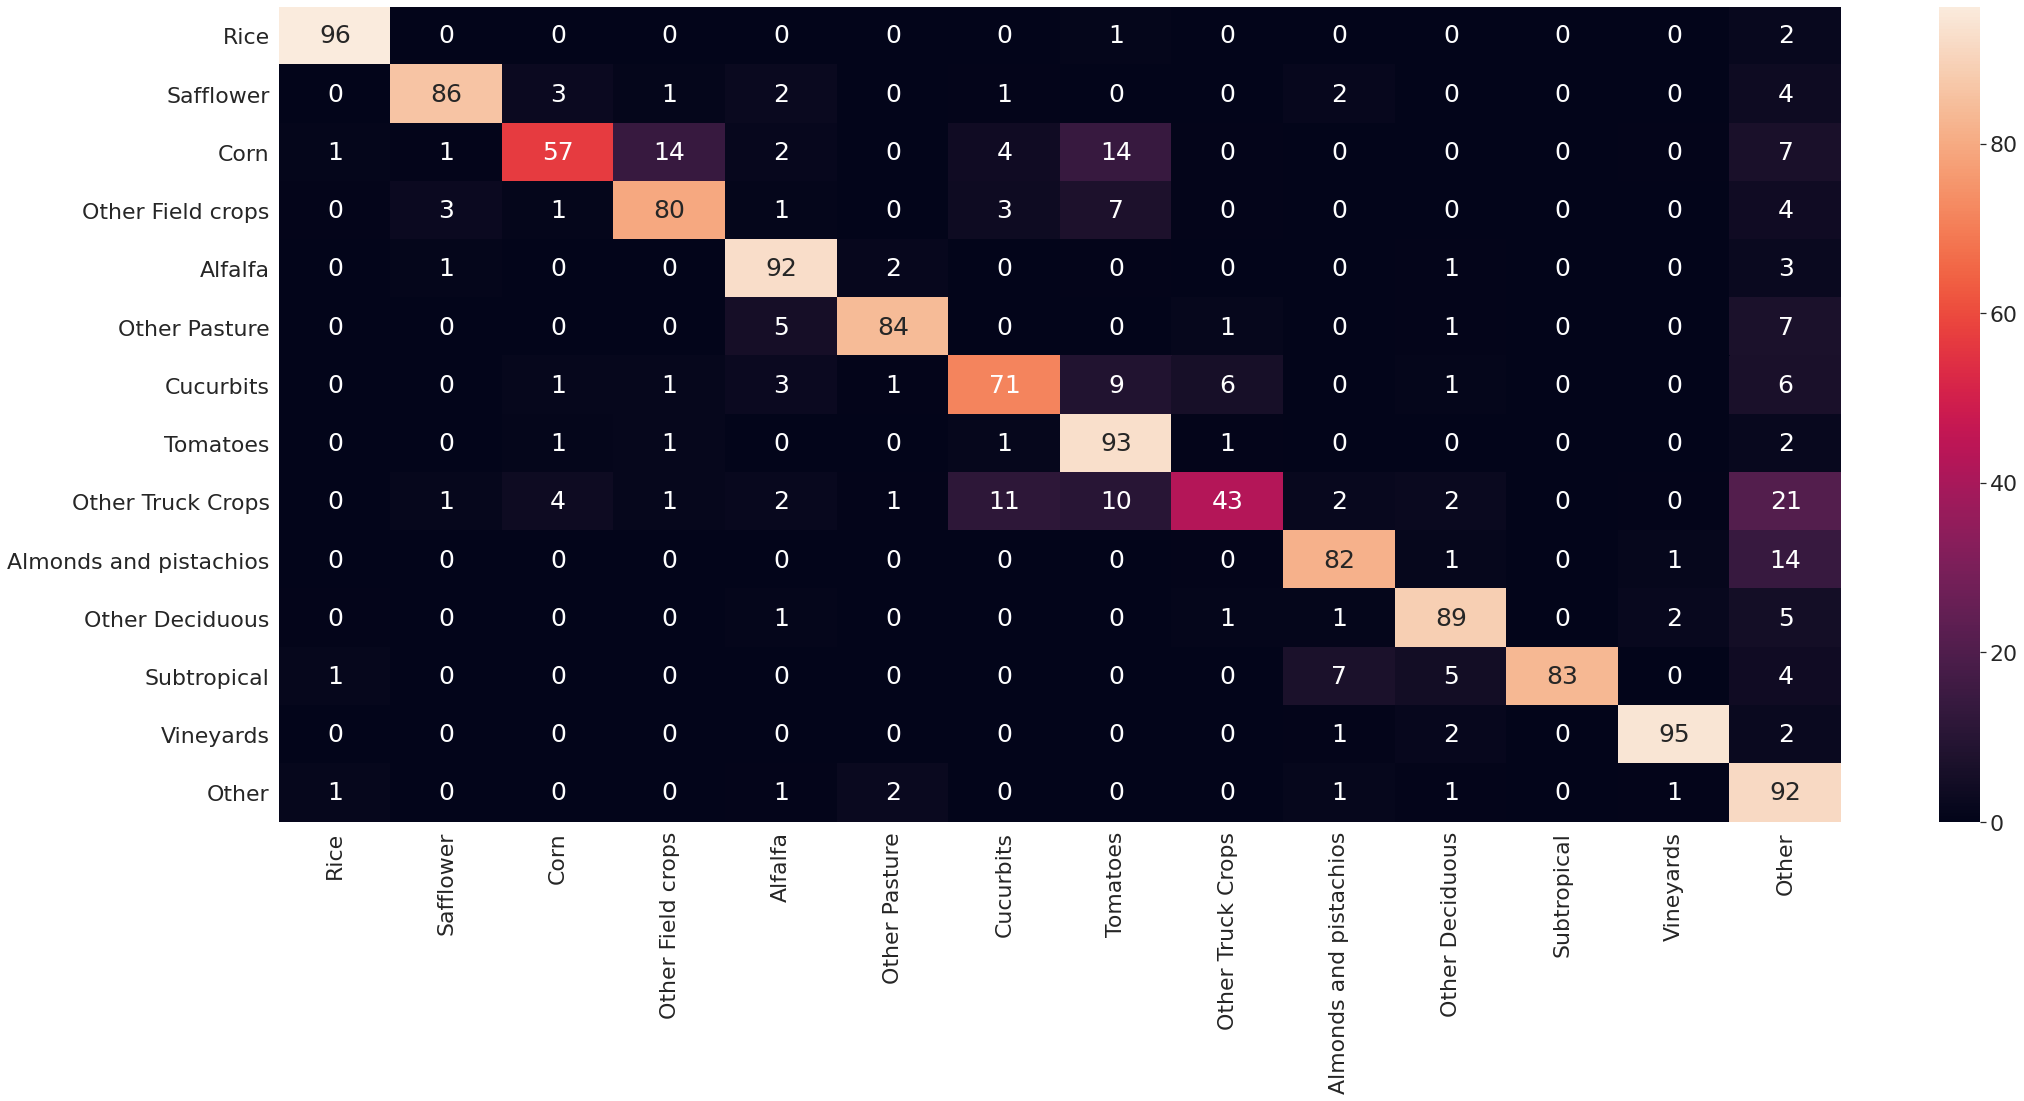

In [32]:
from sklearn.metrics import f1_score
y_pred = np.argmax(model.predict(alltestDataset.batch(1000)),axis = 1)
y_true = tf.concat([y for x, y in alltestDataset], axis=0)

cf = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

print(cf)
s = np.sum(cf, axis = 1)

# cf1 = pd.DataFrame(cf/(s.reshape(nClasses-1, 1)), columns=landcovers[:-1], index = landcovers[:-1])
cf1 = pd.DataFrame((cf/(s.reshape(14, 1)))*100, columns=landcovers, index = landcovers)

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f');

In [34]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average = 'weighted')

0.8836492324812764